# Experiment 2-5 - scaling
- `income_total`이 특정 값에 쏠려있어서 로그를 취해본다.
- 정규화를 진행해본다.
- 나머지 내용은 4와 같음
> `income_total` 로그화 했을 때 성능 미미하게 향상. minmaxscaling 에 대해서는 다른 값에 대해서는 성능이 떨어지고 `income_total`에 대해서만 성능의 변동이 없었다. 나중에 어떻게 할지 결정해야될듯.

In [1]:
from urllib.request import urlretrieve

urlretrieve('https://drive.google.com/uc?export=download&id=1XLVFI_sK0smRVVuT8XU2s-M3lJT-68sN', './open.zip')

('./open.zip', <http.client.HTTPMessage at 0x7f1cac513e90>)

In [2]:
!unzip ./open.zip

Archive:  ./open.zip
   creating: open/
  inflating: open/train.csv          
  inflating: open/sample_submission.csv  
  inflating: open/test.csv           


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA

In [79]:
train = pd.read_csv('./open/train.csv')

In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


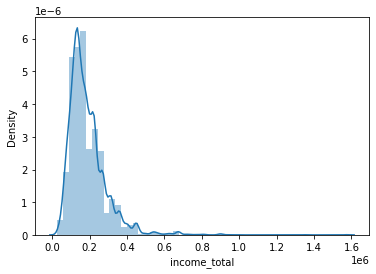

In [81]:
sns.distplot(train['income_total'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


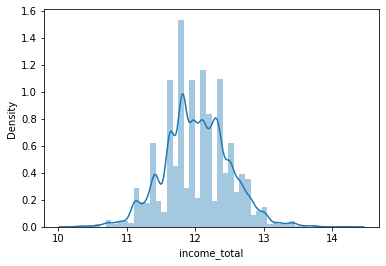

In [13]:
sns.distplot(np.log1p(train['income_total']))

In [26]:
MinMaxScaler().fit_transform(np.log1p(train['income_total'].values.reshape(-1, 1)))

array([[0.49552457],
       [0.54487602],
       [0.69190382],
       ...,
       [0.58596009],
       [0.45394323],
       [0.27017966]])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


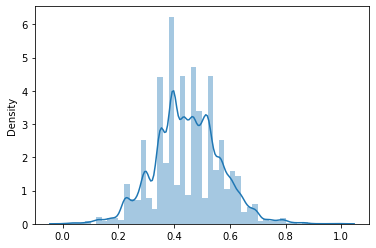

In [27]:
from sklearn.preprocessing import MinMaxScaler

sns.distplot(MinMaxScaler().fit_transform(np.log1p(train['income_total'].values.reshape(-1, 1))))

## Data Preprocessing

In [83]:
train.fillna('NAN', inplace=True)

In [84]:
train.drop('index', axis=1, inplace=True)

In [85]:
train.drop('FLAG_MOBIL', axis=1, inplace=True)

In [86]:
binary_col = ['gender',
              'car',
              'reality']

binary_encoder = OrdinalEncoder(categories=[['F', 'M'],
                                            ['N', 'Y'],
                                            ['N', 'Y']],
                                dtype=np.int8)\
                              .fit(train.loc[:,binary_col])

train.loc[:,binary_col] = binary_encoder.transform(train.loc[:,binary_col])

In [88]:
onehot_col = ['income_type',
              'edu_type',
              'family_type',
              'house_type',
              'occyp_type']


onehot_encoder = OneHotEncoder()
onehot_encoder.fit(train.loc[:,onehot_col])


train_onehot_df = pd.DataFrame(onehot_encoder.transform(train.loc[:,onehot_col]).toarray(), 
             columns=onehot_encoder.get_feature_names(onehot_col))
train.drop(onehot_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

In [90]:
train['parent'] = train['family_size'] - train['child_num']

In [91]:
family_size_cut = 6
child_num_cut = 4

train.loc[train['family_size'] > family_size_cut, 'family_size'] = family_size_cut
train.loc[train['child_num'] > child_num_cut, 'child_num'] = child_num_cut

In [92]:
pca_col = ['family_size', 'child_num', 'parent']
pca = PCA(n_components=1).fit(train.loc[:, pca_col])

train['fcp-pca'] = pca.transform(train.loc[:, pca_col])
train.drop(pca_col, axis=1, inplace=True)

In [93]:
X_train = train.drop('credit', axis=1)
y_train = train['credit']

In [94]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 51 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  26457 non-null  int64  
 1   car                                     26457 non-null  int64  
 2   reality                                 26457 non-null  int64  
 3   income_total                            26457 non-null  float64
 4   DAYS_BIRTH                              26457 non-null  int64  
 5   DAYS_EMPLOYED                           26457 non-null  int64  
 6   work_phone                              26457 non-null  int64  
 7   phone                                   26457 non-null  int64  
 8   email                                   26457 non-null  int64  
 9   begin_month                             26457 non-null  float64
 10  income_type_Commercial associate        26457 non-null  fl

## `income_total` log
> 0이 있을 수도 있다고 판단하여 np.log1p를 사용

`0.7600580763343784` -> `0.7600575656819766` : 미세한 성능 향상...?

In [103]:
X_train_exp = X_train.copy()

In [106]:
X_train_exp['income_total'] = np.log1p(X_train_exp['income_total'])

In [107]:
scores = cross_validate(LGBMClassifier(), X_train_exp, y_train,
                        scoring='neg_log_loss', return_train_score = True)
scores

{'fit_time': array([0.81727886, 0.79461265, 0.8443985 , 0.82562852, 0.79230499]),
 'score_time': array([0.05987191, 0.05487537, 0.0576427 , 0.05495906, 0.0586431 ]),
 'test_score': array([-0.75801923, -0.76170773, -0.76034956, -0.76089536, -0.75931595]),
 'train_score': array([-0.67798479, -0.67827494, -0.67451047, -0.6794452 , -0.6779453 ])}

In [108]:
np.mean(scores['test_score'])

-0.7600575656819766

## scaling
- 위 내용에서 추가

### minmax scaling


In [176]:
X_train_exp = X_train.copy()

In [177]:
X_train_exp['income_total'] = np.log1p(X_train_exp['income_total'])

In [178]:
from sklearn.preprocessing import MinMaxScaler

# scaling_col = ['income_total','DAYS_BIRTH','DAYS_EMPLOYED','begin_month'] # -0.7600876044814232
scaling_col = ['income_total']  # -0.7600575656819766
# scaling_col = ['income_total', 'DAYS_BIRTH'] # -0.7602446675325816
# scaling_col = ['income_total', 'DAYS_EMPLOYED'] # -0.7601856995601253
# scaling_col = ['income_total', 'begin_month'] # 0.7600575656819766
# scaling_col = ['income_total', 'fcp-pca']  # -0.7600606313622581


minmax_scaler = MinMaxScaler().fit(X_train_exp.loc[:, scaling_col])

X_train_exp.loc[:, scaling_col] = minmax_scaler.transform(X_train_exp.loc[:, scaling_col])

In [179]:
X_train_exp['income_total']

0        0.495525
1        0.544876
2        0.691904
3        0.495525
4        0.433718
           ...   
26452    0.521436
26453    0.466558
26454    0.585960
26455    0.453943
26456    0.270180
Name: income_total, Length: 26457, dtype: float64

In [180]:
scores = cross_validate(LGBMClassifier(), X_train_exp, y_train,
                        scoring='neg_log_loss', return_train_score = True)
scores

{'fit_time': array([0.90124202, 0.89656663, 0.91119695, 0.85513544, 0.85989833]),
 'score_time': array([0.06203413, 0.06420779, 0.06513   , 0.066468  , 0.06310534]),
 'test_score': array([-0.75802524, -0.76170773, -0.76035888, -0.76089536, -0.75931595]),
 'train_score': array([-0.67798479, -0.67827494, -0.67451047, -0.6794452 , -0.6779453 ])}

In [181]:
np.mean(scores['test_score'])

-0.7600606313622581

### standard scaling
> `income_total` 이 bell-shape 이라 생각해서 standard scaling 도 괜찮을 것이라 생각했지만 성능은 떨어졌다.

In [150]:
X_train_exp = X_train.copy()

In [151]:
X_train_exp['income_total'] = np.log1p(X_train_exp['income_total'])

In [154]:
from sklearn.preprocessing import StandardScaler

scaling_col = ['income_total']

std_scaler = StandardScaler().fit(X_train_exp.loc[:, scaling_col])

X_train_exp.loc[:, scaling_col] = std_scaler.transform(X_train_exp.loc[:, scaling_col])

In [155]:
scores = cross_validate(LGBMClassifier(), X_train_exp, y_train,
                        scoring='neg_log_loss', return_train_score = True)
scores

{'fit_time': array([0.83558726, 0.84871435, 0.85288763, 0.85903883, 0.84871745]),
 'score_time': array([0.05969739, 0.05647945, 0.06421471, 0.0591979 , 0.05650926]),
 'test_score': array([-0.75801923, -0.76170773, -0.76034956, -0.76097735, -0.75931551]),
 'train_score': array([-0.67798479, -0.67827494, -0.67451047, -0.67923773, -0.6779453 ])}

In [156]:
np.mean(scores['test_score'])

-0.760073875644165

## validate

In [ ]:
scores = cross_validate(LGBMClassifier(), X_train, y_train,
                        scoring='neg_log_loss', return_train_score = True)
scores

{'fit_time': array([1.01751852, 0.98121119, 0.99040604, 0.9858973 , 1.0141592 ]),
 'score_time': array([0.05916309, 0.07506967, 0.06144333, 0.0611012 , 0.06625652]),
 'test_score': array([-0.75942811, -0.76384856, -0.76256046, -0.76210299, -0.75800922]),
 'train_score': array([-0.68033952, -0.67795626, -0.6758315 , -0.67947138, -0.67699941])}

In [ ]:
np.mean(scores['test_score'])

-0.7611898663220819